In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import pandas.util.testing as tm
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import tqdm
seed = 42

In [7]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

## Explorative Data Analysis

In [8]:
print(f"Train data shape is:",train.shape)
print(f"Test data shape is:",test.shape)

Train data shape is: (250, 302)
Test data shape is: (19750, 301)


There are 250 data points in the train data with 302 columns while the test data has 19750 datapoints and 301 columns.

In [9]:
train.describe()

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,124.500000,0.640000,0.023292,-0.026872,0.167404,0.001904,0.001588,-0.007304,0.032052,0.078412,...,0.044652,0.126344,0.018436,-0.012092,-0.065720,-0.106112,0.046472,0.006452,0.009372,-0.128952
std,72.312977,0.480963,0.998354,1.009314,1.021709,1.011751,1.035411,0.955700,1.006657,0.939731,...,1.011416,0.972567,0.954229,0.960630,1.057414,1.038389,0.967661,0.998984,1.008099,0.971219
min,0.000000,0.000000,-2.319000,-2.931000,-2.477000,-2.359000,-2.566000,-2.845000,-2.976000,-3.444000,...,-2.804000,-2.443000,-2.757000,-2.466000,-3.287000,-3.072000,-2.634000,-2.776000,-3.211000,-3.500000
25%,62.250000,0.000000,-0.644750,-0.739750,-0.425250,-0.686500,-0.659000,-0.643750,-0.675000,-0.550750,...,-0.617000,-0.510500,-0.535750,-0.657000,-0.818500,-0.821000,-0.605500,-0.751250,-0.550000,-0.754250
50%,124.500000,1.000000,-0.015500,0.057000,0.184000,-0.016500,-0.023000,0.037500,0.060500,0.183500,...,0.067500,0.091000,0.057500,-0.021000,-0.009000,-0.079500,0.009500,0.005500,-0.009000,-0.132500
75%,186.750000,1.000000,0.677000,0.620750,0.805000,0.720000,0.735000,0.660500,0.783250,0.766250,...,0.797250,0.804250,0.631500,0.650250,0.739500,0.493000,0.683000,0.794250,0.654250,0.503250
max,249.000000,1.000000,2.567000,2.419000,3.392000,2.771000,2.901000,2.793000,2.546000,2.846000,...,2.865000,2.801000,2.736000,2.596000,2.226000,3.131000,3.236000,2.626000,3.530000,2.771000


Train data is within a sizeable range with no outlier in sight.

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Columns: 302 entries, id to 299
dtypes: float64(301), int64(1)
memory usage: 590.0 KB


The train data are all numeric data, mostly float datatype (continuous) and only one integer.

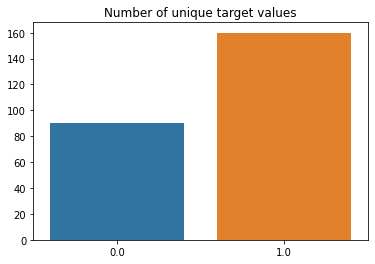

In [11]:
sns.barplot(x=train['target'].value_counts().index, y=train['target'].value_counts().values)
plt.title('Number of unique target values')
plt.show()

In [12]:
total_num = train.shape[0]
count_1, count_0 = train['target'].value_counts().values
print('Fraction of dataset contain total number of 0s:',(count_0/total_num)*100,'%')
print('Fraction of dataset contain total number of 1s:',(count_1/total_num)*100,'%')

Fraction of dataset contain total number of 0s: 36.0 %
Fraction of dataset contain total number of 1s: 64.0 %


Target value is not balanced. Accuracy is not a good metric for this problem.


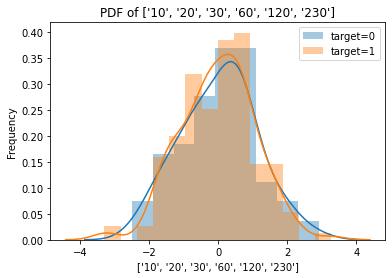

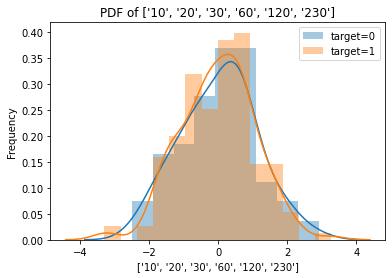

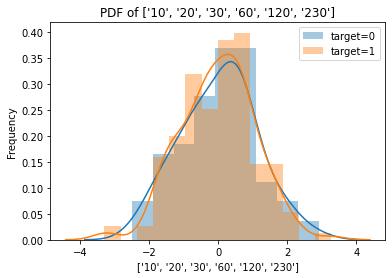

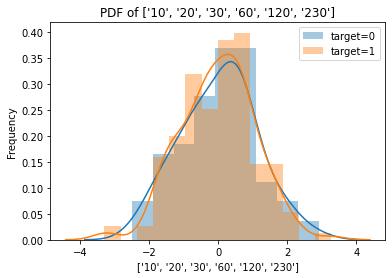

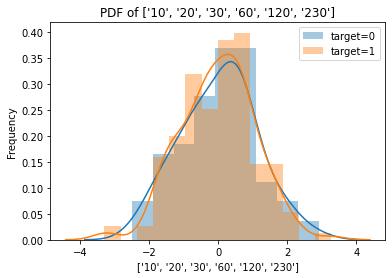

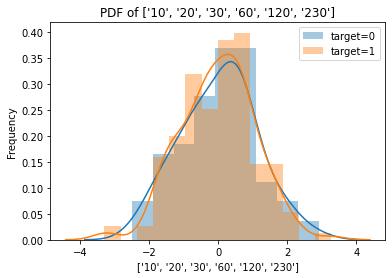

In [13]:
#Reveal some pattern about those that failed and those that did not
cols = ['10','20', '30','60', '120', '230']
for c in cols:
    sns.distplot(train[train['target']==0][str(cols[0])], label='target=0')
    sns.distplot(train[train['target']==1][str(cols[0])], label='target=1')
    plt.legend(loc='upper right')
    plt.xlabel(cols)
    plt.ylabel('Frequency')
    plt.title('PDF of {}'.format(cols))
    plt.show()

The target 1 and 0 overlaps, this will make it harder to get a good prediction on the data set.

### Feature Engineering

In [14]:
def feature_eng(df, if_test=False):
    """
    Parameter:
    df: dataframe on which the feature engineering is to be performed
    if_test: A boolean True if the dataframe is the test set or False if it is the train set 
    
    Return:
    Addition columns such as:
    mean: mean of the entire columns,
    std: standarad deviation of the entire column,
    mean_sin: mean of the sine,
    mean_cos: mean of the cosine,
    mean_tan: mean of the tangent,
    mean_sinh: mean of the sinh
    mean_cosh: mean of the cosh,
    mean_tanh: mean of the tanh,
    mean_exp: mean of the exponential
    mean_expm1: mean of exp(x)-1
    mean_exp2: mean of 2**x
    mean_x2: mean of x raise to power 2
    mean_x3: mean of x raise to power 3
    mean_x4: mean of x raise to power 4
    """

    if if_test:
      temp = df.drop(['id'], axis=1)
    else:
      temp = df.drop(['id','target'], axis=1)

    df['mean'] = np.mean(temp, axis=1)
    df['std'] = np.std(temp, axis=1)
    sin_temp = np.sin(temp)
    cos_temp = np.cos(temp)
    tan_temp = np.tan(temp)
    df['mean_sin'] = np.mean(sin_temp, axis=1)
    df['mean_cos'] = np.mean(cos_temp, axis=1)
    df['mean_tan'] = np.mean(tan_temp, axis=1)
    sinh_temp = np.sinh(temp)
    cosh_temp = np.cosh(temp)
    tanh_temp = np.tanh(temp)
    df['mean_sinh'] = np.mean(sinh_temp, axis=1)
    df['mean_cosh'] = np.mean(cosh_temp, axis=1)
    df['mean_tanh'] = np.mean(tanh_temp, axis=1)
    exp_temp = np.exp(temp)
    expm1_temp = np.expm1(temp)
    exp2_temp = np.exp2(temp)
    df['mean_exp'] = np.mean(exp_temp, axis=1)
    df['mean_expm1'] = np.mean(expm1_temp, axis=1)
    df['mean_exp2'] = np.mean(exp2_temp, axis=1)
    df['mean_x2'] = np.mean(np.power(temp,2), axis=1)
    df['mean_x3'] = np.mean(np.power(temp,3), axis=1)
    df['mean_x4'] = np.mean(np.power(temp,4), axis=1)
    return df

In [15]:
train_to_fe = train.copy()
train_fe = feature_eng(train_to_fe,False)
print("Feature engineering performed on train")
test_to_fe = test.copy()
test_fe = feature_eng(test_to_fe, True)
print("Feature engineering performed on test")

Feature engineering performed on train
Feature engineering performed on test


## Modeling

In [16]:
# Raw Data
y = train['target']
train_drop = train.drop(['id', 'target'], axis=1)
test_drop = test.drop(['id'], axis=1)
df_train = train_drop.copy()
y_train = y.copy()
print(df_train.shape)
print(y_train.shape)

(250, 300)
(250,)


In [17]:
scale = StandardScaler()
df_train_scaled = scale.fit_transform(df_train)
print("Train data scaled")
test_scaled = scale.transform(test_drop)
print("Test data scaled")


Train data scaled
Test data scaled


In [18]:
y_train_fe = train_fe['target']
train_drop_fe = train_fe.drop(['id', 'target'], axis=1)
test_drop_fe = test_fe.drop(['id'], axis=1)
#Scale data
train_fe_scaled = scale.fit_transform(train_drop_fe)
print("Engineered train data scaled")
test_fe_scaled = scale.transform(test_drop_fe)
print("Engineered test data scaled")

Engineered train data scaled
Engineered test data scaled


In [19]:
def hyperparameter_model(models, params, x_train, y_train):
    '''
    Hyperparameter tuning with StratifiedKFold follow by GridSearchCV follow by CalibratedClassifier
    
    Parameters:
    models: Instance of the model
    params: list of parameters with value fr tuning (dict)
    
    Return:
    grid_clf: return gridsearch model    
    '''
    str_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
    grid_clf = GridSearchCV(models, params, cv=str_cv, return_train_score=True, scoring='roc_auc')
    grid_clf.fit(x_train, y_train)
    return grid_clf

def forward_selection_model(x_train, y_train,model, top_n=10):
    # List of top feature column variable
    top_column = []
    # To store cross val score
    exist_score = 0
    # Iterate over till number of top feature desired
    for n in range(top_n):
        print('for {} feature'.format(n+1))
        flag = 0
        # Iterate over all the feature in train data
        for i in tqdm.tqdm_notebook(range(test_scaled.shape[1])):
            # Finding for first top feature
            if len(top_column) == 0:
                str_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
                score = cross_val_score(model,x_train[:,[i]],y_train,cv=str_cv,scoring='roc_auc')
                if exist_score < np.mean(score):
                    top_current = i
                    exist_score = np.mean(score)
                    flag = 1
            # Excluded apart from top column
            elif i not in top_column:
                str_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
                score = cross_val_score(model,x_train[:,np.concatenate((top_column,[i]))],y_train,cv=str_cv,scoring='roc_auc')
                if exist_score < np.mean(score):
                    top_current = i
                    exist_score = np.mean(score)
                    flag = 1
        
        if flag == 1:
            print('Current top feature {} and score: {}'.format(top_current,exist_score))
            print('Appended to top column')
            top_column.append(top_current)
            print(top_column)
        else:
            break
    return top_column

def plot_feature_importance(model, model_name, top_n = 10):
    '''
    Compute ROC curve and ROC area for each class
    
    Parameters:
    try_true: train true label
    try_pred: train predict probabilities value
    cvy_true: cv true label
    cvy_pred: cv predict probabilities value
    n_classes: number of unique classes
    
    Return:
    Plot of ROC Curve for train and cv data    
    '''       
    column_name = train.drop(['id','target'], axis=1).columns
    if model_name == 'log_model':
        feat_imp_coef = model.coef_.ravel()
    else:
        feat_imp_coef = model.feature_importances_
    temp = pd.DataFrame(data=np.column_stack((column_name, feat_imp_coef)), columns=['col_name','coef'])
    temp = temp.sort_values(by='coef', ascending=False).reset_index()
    df = temp
    temp = temp[:top_n]
    return temp

### A. Baseline Model - Logistic Regression

In [20]:
log_reg = LogisticRegression(random_state=seed)
log_reg.fit(df_train_scaled,y_train)

LogisticRegression(random_state=42)

The baseline logistic regression had a score of 0.737 on the leaderboard.

#### Standardization + ML Classification model without top features

### B. Logistic Regression with optimization


> With all features



In [21]:
params = {'penalty':['l1', 'l2', 'elasticnet'], 'C':[10**i for i in range(-4,5)], 'solver':['liblinear','sag']}
log_model = LogisticRegression(random_state=42, class_weight='balanced')
log_clf = hyperparameter_model(log_model, params, df_train_scaled, y_train)
print(log_clf.best_params_)

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


In [22]:
log_model = LogisticRegression(**log_clf.best_params_, class_weight='balanced', random_state=42)
log_model.fit(df_train_scaled, y_train)

LogisticRegression(C=0.1, class_weight='balanced', penalty='l1',
                   random_state=42, solver='liblinear')

Score was 0.848 with all the data scaled for logistic regression and hyperparameter optimization applied.



> With top 10 features using Forward Selection process



In [23]:
top_column = forward_selection_model(df_train_scaled,y_train,log_model)
print(f"Top selected column for Logistic Regression are:",top_column)

for 1 feature



Current top feature 33 and score: 0.7347222222222222
Appended to top column
[33]
for 2 feature



Current top feature 65 and score: 0.7876388888888887
Appended to top column
[33, 65]
for 3 feature



Current top feature 217 and score: 0.8005555555555557
Appended to top column
[33, 65, 217]
for 4 feature



Current top feature 117 and score: 0.8156944444444443
Appended to top column
[33, 65, 217, 117]
for 5 feature



Current top feature 91 and score: 0.8325
Appended to top column
[33, 65, 217, 117, 91]
for 6 feature



Current top feature 73 and score: 0.8423611111111111
Appended to top column
[33, 65, 217, 117, 91, 73]
for 7 feature



Current top feature 16 and score: 0.8493055555555555
Appended to top column
[33, 65, 217, 117, 91, 73, 16]
for 8 feature



Current top feature 226 and score: 0.852777777777778
Appended to top column
[33, 65, 217, 117, 91, 73, 16, 226]
for 9 feature



Current top feature 82 and score: 0.8559722222222222
Appended to top column
[33, 65, 217, 117, 91, 73, 16, 226, 82]
for 10 feature



Current top feature 90 and score: 0.8590277777777778
Appended to top column
[33, 65, 217, 117, 91, 73, 16, 226, 82, 90]
Top selected column for Logistic Regression are: [33, 65, 217, 117, 91, 73, 16, 226, 82, 90]


In [24]:
log_top10_feat = set(top_column)
log_model_top10 = LogisticRegression(**log_clf.best_params_, class_weight='balanced', random_state=42)
log_model_top10.fit(df_train_scaled[:,top_column],y_train)

LogisticRegression(C=0.1, class_weight='balanced', penalty='l1',
                   random_state=42, solver='liblinear')

Obtained a score of 0.832 with the top model selected. Maybe increasing the number of top_n might increase the score. But what is an ideal top_n in this case? 

### C. Random Forest Classifier

In [25]:
rf = RandomForestClassifier(random_state=seed)
rf.fit(df_train_scaled,y_train)
print("Random forest trained on scaled data")

Random forest trained on scaled data


Observed a score of 0.662 on the leaderboard on random forest model , all data scaled without optimization

### D. Random Forest with optimization


> With all features


In [26]:
params = {'n_estimators':[10,20,30,40,50,100,200,300,400],'max_depth':[2,3,5,7]}
rf_model = RandomForestClassifier(random_state=seed)
rf_clf = hyperparameter_model(rf_model, params,df_train_scaled, y_train)
print(rf_clf.best_params_)
rf_clf = RandomForestClassifier(**rf_clf.best_params_,random_state=seed)
rf_clf.fit(df_train_scaled, y_train)

{'max_depth': 2, 'n_estimators': 300}


RandomForestClassifier(max_depth=2, n_estimators=300, random_state=42)

The random forest model improved significantly when optimized compared to its non-optimized.



> With top 10 features using Forward Selection process



In [27]:
# top_column = forward_selection_model(df_train_scaled,y_train,rf_clf)
# print(f"Top selected column in Random Forest model are:",top_column)

In [28]:
top_column = [33, 65, 91, 199, 217, 214, 189, 132]
rf_top10_feat = set(top_column)
rf_model_top10 = RandomForestClassifier(max_depth=2, n_estimators=300,random_state=seed)
rf_model_top10.fit(df_train_scaled[:,top_column],y_train)

RandomForestClassifier(max_depth=2, n_estimators=300, random_state=42)

With top ten features in the RF model, I obtained a score of 0.779

### E. Support Vector Classifier

In [39]:
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

params = {'C':[10**i for i in range(-4,5)], 'kernel':['linear','poly','sigmoid','rbf']}
svc_model = SVC(class_weight='balanced', random_state=seed, probability=True)
svc_clf = hyperparameter_model(svc_model, params,df_train_scaled,y_train)
print(svc_clf.best_params_)
svc_clf = SVC(**svc_clf.best_params_,random_state=seed,probability=True)
svc_clf.fit(df_train_scaled, y_train)

{'C': 10, 'kernel': 'rbf'}


SVC(C=10, probability=True, random_state=42)

### E. Logistic Regression with Feature Engineered Data


> With All Data



In [31]:
log_reg_fe = LogisticRegression(random_state=seed)
log_reg_fe.fit(train_fe_scaled, y_train_fe)

LogisticRegression(random_state=42)

Score: 0.738
The modeling of the engineered data performed slightly better than the raw data with a difference in score of 0.01.

> With hyperparameter optimization

In [35]:
params = {'penalty':['l1', 'l2', 'elasticnet'], 'C':[10**i for i in range(-4,5)], 'solver':['liblinear','sag']}
log_model = LogisticRegression(random_state=42, class_weight='balanced')
log_clf_fe = hyperparameter_model(log_model, params, train_fe_scaled, y_train_fe)
print(log_clf_fe.best_params_)

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


In [36]:
log_model_fe = LogisticRegression(**log_clf_fe.best_params_, class_weight='balanced', random_state=42)
log_model_fe.fit(train_fe_scaled, y_train_fe)

LogisticRegression(C=0.1, class_weight='balanced', penalty='l1',
                   random_state=42, solver='liblinear')

Score:0.849. The modeling of the engineered data performed slightly better than the raw data with a difference in score of 0.01.

### F. Random Forest Classifier with Feature Engineered Data


> With All Data


In [38]:
rf_fe = RandomForestClassifier(random_state=seed)
rf_fe.fit(train_fe_scaled, y_train_fe)
print("Random forest trained on scaled engineered data")

Random forest trained on scaled engineered data


The random forest model on the featured engineered data performed well over the raw scaled data (0.662), with a score of 0.689.



> With optimization



In [43]:
params = {'n_estimators':[10,20,30,40,50,100,200,300,400],'max_depth':[2,3,5,7]}
rf_model = RandomForestClassifier(random_state=seed)
rf_clf_fe = hyperparameter_model(rf_model, params,train_fe_scaled, y_train_fe)
print(rf_clf_fe.best_params_)
rf_clf_fe = RandomForestClassifier(**rf_clf_fe.best_params_,random_state=seed)
rf_clf_fe.fit(train_fe_scaled, y_train_fe)

{'max_depth': 2, 'n_estimators': 400}


RandomForestClassifier(max_depth=2, n_estimators=400, random_state=42)

With optimization, the model did better with a score of 0.756 compared to the model with the raw data (0.734)

### H. SVC with optimization on feature engineered data

In [41]:
params = {'C':[10**i for i in range(-4,5)], 'kernel':['linear','poly','sigmoid','rbf']}
svc_model = SVC(class_weight='balanced', random_state=seed, probability=True)
svc_clf_fe = hyperparameter_model(svc_model, params,train_fe_scaled, y_train_fe)
print(svc_clf_fe.best_params_)
svc_clf_fe = SVC(**svc_clf_fe.best_params_,random_state=seed,probability=True)
svc_clf_fe.fit(train_fe_scaled, y_train_fe)

{'C': 10, 'kernel': 'rbf'}


SVC(C=10, probability=True, random_state=42)

## Conclusion on all models

In [43]:
x = PrettyTable()
x.field_names = ['Model','Features','LeaderBoard Score']
x.add_row(['Logistic Regression','All Data - scaled',0.737])
x.add_row(['Logistic Regression with hyperparameter','All Data - scaled',0.848])
x.add_row(['Logistic Regression with hyperparameter','Forward selection-top 10',0.832])
x.add_row(['Random Forest Classifier','All Data - scaled',0.662])
x.add_row(['Random Forest Classifier with hyperparameter','All Data - scaled',0.734])
x.add_row(['Random Forest Classifier with hyperparameter','Forward selection-top 10',0.779])
x.add_row(['Support Vector Classifier with hyperparameter','All Data - scaled',0.756])
print(x)

+-----------------------------------------------+--------------------------+-------------------+
|                     Model                     |         Features         | LeaderBoard Score |
+-----------------------------------------------+--------------------------+-------------------+
|              Logistic Regression              |    All Data - scaled     |       0.737       |
|    Logistic Regression with hyperparameter    |    All Data - scaled     |       0.848       |
|    Logistic Regression with hyperparameter    | Forward selection-top 10 |       0.832       |
|            Random Forest Classifier           |    All Data - scaled     |       0.662       |
|  Random Forest Classifier with hyperparameter |    All Data - scaled     |       0.734       |
|  Random Forest Classifier with hyperparameter | Forward selection-top 10 |       0.779       |
| Support Vector Classifier with hyperparameter |    All Data - scaled     |       0.756       |
+-----------------------------

In [45]:
y = PrettyTable()
y.field_names = ['Model','Features','LeaderBoard Score']
y.add_row(['Logistic Regression','Feature Engineered - scaled',0.738])
y.add_row(['Logistic Regression with hyperparameter','Feature Engineered - scaled',0.848])
y.add_row(['Random Forest Classifier','Feature Engineered - scaled',0.662])
y.add_row(['Random Forest Classifier with hyperparameter','Feature Engineered - scaled',0.734])
x.add_row(['Support Vector Classifier with hyperparameter','Feature Engineered - scaled',0.743])
print(y)

+----------------------------------------------+-----------------------------+-------------------+
|                    Model                     |           Features          | LeaderBoard Score |
+----------------------------------------------+-----------------------------+-------------------+
|             Logistic Regression              | Feature Engineered - scaled |       0.738       |
|   Logistic Regression with hyperparameter    | Feature Engineered - scaled |       0.848       |
|           Random Forest Classifier           | Feature Engineered - scaled |       0.662       |
| Random Forest Classifier with hyperparameter | Feature Engineered - scaled |       0.734       |
+----------------------------------------------+-----------------------------+-------------------+


Using the raw data as is with hyperparameter optimization on logistic regression model performed better than the rest of the models.

In [42]:

# Create a submssion format to make submission in Kaggle
temp_id = test['id']
svc_csv = svc_clf_fe.predict_proba(test_fe_scaled)[:,1]
svc_df = pd.DataFrame(np.column_stack((temp_id,svc_csv)), columns=['id','target'])
svc_df['id'] = svc_df['id'].astype('int32')
svc_df.to_csv('submission_53.csv', index=False)